In [26]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [27]:
data = pd.read_csv('mnist_test.csv')

In [28]:
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
data = np.array(data)

#m is the number of entries (rows), n = number of features + 1
m, n = data.shape

#randomly shuffle the data to be split into training and test data (prevents bias)
np.random.shuffle(data)

#first 1000 examples 
#.T transposes data so that each column is one example
#each row now represents the value each image has at that pixel
data_dev = data[0:1000].T

#Y_dev first row is separated, so Y_dev contains the true labels (what each number is supposed to be)
Y_dev = data_dev[0]

#X_dev contains the pixel data (test set)
X_dev = data_dev[1:n]

#same for training data
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
#normalize pixel values by dividing by 255, scaling pixel values to [0, 1]
X_train = X_train / 255.

In [32]:
def init_params():
    # Initialize weight matrices and bias vectors with random values between -0.5 and 0.5
    # W1: (10, 784) - 10 neurons in the hidden layer, 784 input features (28x28 pixel images)
    W1 = np.random.rand(10, 784) - 0.5
    # b1: (10, 1) - Bias for each neuron in the hidden layer
    b1 = np.random.rand(10, 1) - 0.5
    # W2: (10, 10) - 10 neurons in the output layer, 10 neurons from the hidden layer
    W2 = np.random.rand(10, 10) - 0.5
    # b2: (10, 1) - Bias for each neuron in the output layer
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    # Apply ReLU activation function element-wise: max(0, Z)
    # Z: (n, m) - input matrix
    return np.maximum(0, Z)

def softmax(Z):
     # Apply softmax activation function
    # Z: (10, m) - raw scores for each class
    # Compute exponentials and normalize by sum across each column
    
    # Subtract max of Z from each element for numerical stability
    Z_max = np.max(Z, axis=0, keepdims=True)  # Find max value per column (for each example)
    exp_Z = np.exp(Z - Z_max)  # Exponentiate after stabilization
    A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)  # Normalize
    return A

def forward_prop(W1, b1, W2, b2, X):
    # Forward propagation step
    # X: (784, m) - input features (each column is an example)
    # W1: (10, 784), b1: (10, 1)
    # each pixel gets its own weight, each neuron (i.e. the 10 outputs) gets a bias
    # b1 is broadcast to a (10, m) matrix when addition is performed (biases are copied across each column)
    # Z1: (10, m) - weighted sum of inputs to the hidden layer
    Z1 = W1.dot(X) + b1
    # A1: (10, m) - activation output of hidden layer
    A1 = ReLU(Z1)
    # W2: (10, 10), b2: (10, 1)
    # Z2: (10, m) - weighted sum of inputs to output layer
    Z2 = W2.dot(A1) + b2
    # A2: (10, m) - final output probabilities for each class
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    # Derivative of ReLU function
    # Returns a matrix where elements are 1 if Z > 0, else 0
    return Z > 0

def one_hot(Y):
    # Convert labels to one-hot encoding
    # Y: (m,) - vector of labels
    # one_hot_Y: (10, m) - one-hot encoded matrix of labels
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1  # Set correct class index to 1
    return one_hot_Y.T  # Transpose to match output dimensions (10, m)

def backward_prop(Z1, A1, Z2, A2, W2, X, Y):
    # Backward propagation step
    # X: (784, m), A1: (10, m), A2: (10, m)
    # Y: (m,) - ground truth labels
    m = Y.size  # Number of training examples
    one_hot_Y = one_hot(Y)  # Convert Y to one-hot encoding (10, m)
    
    # Compute gradients for output layer
    dZ2 = A2 - one_hot_Y  #dZ2 = dL/dZ2
                          # (10, m) - error at output (gradient of loss with respect to Z2; appears linear bc we
                          # use cross entropy loss, which simplifies gradient computation
    dW2 = (1 / m) * dZ2.dot(A1.T) 
                          # dZ2/dW2 = A1.T
                          # (10, 10) - gradient of W2 (how does the loss function change with respect to W2's weights)
                          # division by m so that it represents how much each individual neuron contributed to error
                          # dW2 = 1/m (dZ2 * A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)  # (10, 1) - gradient of b2
                          # dL/db2 = dL/dZ2 * dZ2/db2= dL/dZ2 * 1 --> divided by m to average over batch, because
                          # the sum would otherwise grow with the number of samples (m)
    
    # Compute gradients for hidden layer
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)  # (10, m) - backpropagated error
    dW1 = (1 / m) * dZ1.dot(X.T)  # (10, 784) - gradient of W1
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)  # (10, 1) - gradient of b1
    
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    # Update parameters using gradient descent
    # alpha - learning rate
    W1 = W1 - alpha * dW1  # Update W1 (10, 784)
    b1 = b1 - alpha * db1  # Update b1 (10, 1)
    W2 = W2 - alpha * dW2  # Update W2 (10, 10)
    b2 = b2 - alpha * db2  # Update b2 (10, 1)
    return W1, b1, W2, b2


In [33]:
def get_predictions(A2):
    #get prediction from matrix
    #0 is rows, returns a 1xm matrix where the value in each index is the highest probability 
    #in that column 
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    #Y = true labels, predictions = predicted labels
    #predictions == Y creates array of 0's and 1's to see which labels match up
    #e.g. [1, 2, 4] == [1, 2, 3] -> [1, 1, 0]
    print(predictions, Y)
    return np.sum(predictions == Y)/Y.size


def gradient_descent(X, Y, iterations, alpha):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations): 
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 50 == 0:
            print("Iteration: ", i)
            print("Accuracy: ", get_accuracy(get_predictions(A2), Y))

    return W1, b1, W2, b2

In [34]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 500, 0.1)

Iteration:  0
[3 7 0 ... 7 3 4] [7 7 6 ... 8 7 8]
Accuracy:  0.10911111111111112
Iteration:  50
[9 7 5 ... 1 7 6] [7 7 6 ... 8 7 8]
Accuracy:  0.5605555555555556
Iteration:  100
[9 7 5 ... 1 7 8] [7 7 6 ... 8 7 8]
Accuracy:  0.7152222222222222
Iteration:  150
[9 7 5 ... 1 7 8] [7 7 6 ... 8 7 8]
Accuracy:  0.78
Iteration:  200
[9 7 5 ... 1 7 8] [7 7 6 ... 8 7 8]
Accuracy:  0.8138888888888889
Iteration:  250
[9 7 5 ... 1 7 8] [7 7 6 ... 8 7 8]
Accuracy:  0.8354444444444444
Iteration:  300
[9 7 5 ... 1 7 8] [7 7 6 ... 8 7 8]
Accuracy:  0.8491111111111111
Iteration:  350
[9 7 5 ... 1 7 8] [7 7 6 ... 8 7 8]
Accuracy:  0.859
Iteration:  400
[9 7 6 ... 8 7 8] [7 7 6 ... 8 7 8]
Accuracy:  0.866
Iteration:  450
[7 7 6 ... 8 7 8] [7 7 6 ... 8 7 8]
Accuracy:  0.8728888888888889


In [35]:
def make_predictions(X, W1, b1, W2, b2):
    #using weights and biases, create the matrix and get the prediction from it (get prediction from weights and set)
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()




Prediction:  [7]
Label:  7


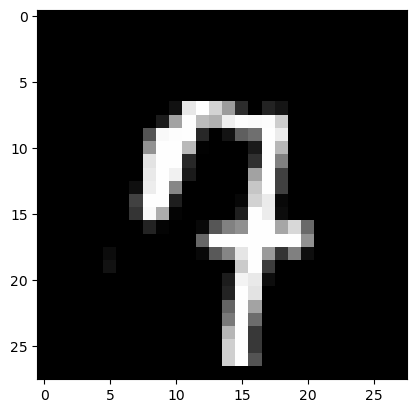

In [36]:
test_prediction(0, W1, b1, W2, b2)

In [37]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)
#84.3% accuracy

[9 3 7 9 5 1 3 9 3 9 7 9 1 3 5 3 2 2 8 4 0 4 1 1 9 3 0 2 8 3 8 2 1 1 3 8 9
 7 9 2 7 1 1 7 7 3 9 9 2 8 8 0 4 2 7 8 8 2 7 9 6 4 3 0 4 3 4 5 0 2 6 8 6 2
 0 0 7 6 6 6 0 1 2 8 1 4 7 0 6 9 0 2 8 6 7 4 1 9 9 6 8 0 7 7 1 1 4 2 1 4 3
 1 2 5 2 8 1 6 8 4 9 8 1 0 2 9 8 0 7 4 0 5 0 7 8 5 4 7 8 7 5 1 3 3 0 0 4 7
 7 5 7 9 9 9 5 1 9 1 5 6 8 2 1 9 5 9 8 9 0 9 8 8 8 3 1 8 9 7 8 2 5 6 3 4 9
 8 7 8 6 9 6 7 8 8 3 2 4 5 2 2 0 4 4 1 1 0 6 7 3 7 0 3 0 4 5 5 2 4 0 3 9 8
 7 3 9 9 2 8 7 1 5 5 0 3 2 6 2 0 6 9 2 8 7 9 1 8 9 3 2 1 0 7 8 5 4 7 0 6 1
 5 4 6 8 4 3 0 0 2 5 2 7 3 6 0 2 1 6 7 8 1 7 7 8 4 8 7 8 7 7 4 2 5 1 8 2 1
 7 2 2 5 2 9 3 7 2 2 3 6 3 8 1 7 9 1 3 9 3 7 4 9 8 7 9 9 6 8 0 9 9 4 9 0 0
 1 2 6 8 3 8 8 6 6 7 6 5 6 1 4 5 4 1 7 1 1 4 1 9 8 5 6 4 1 2 0 2 5 6 9 7 0
 0 1 3 1 1 1 1 4 7 8 1 3 4 2 3 5 2 4 6 2 3 8 0 1 9 0 4 8 2 4 7 0 3 4 3 8 2
 5 1 1 1 8 9 7 2 4 3 8 4 3 5 4 5 3 9 3 2 4 6 4 2 7 1 7 6 4 2 0 4 6 7 3 6 5
 1 8 4 9 0 6 4 8 2 9 7 6 5 2 7 8 9 4 2 3 2 3 6 1 7 9 8 7 1 4 8 1 4 9 4 3 9
 7 5 6 5 0 0 8 8 0 1 0 8 

0.843